# TODS

## Introduction Summary

TODS is a full-stack automated machine learning system for outlier detection on multivariate time-series data. TODS provides exhaustive modules for building machine learning-based outlier detection systems, including: data processing, time series processing, feature analysis (extraction), detection algorithms, and reinforcement module. The functionalities provided via these modules include data preprocessing for general purposes, time series data smoothing/transformation, extracting features from time/frequency domains, various detection algorithms, and involving human expertise to calibrate the system. Three common outlier detection scenarios on time-series data can be performed: point-wise detection (time points as outliers), pattern-wise detection (subsequences as outliers), and system-wise detection (sets of time series as outliers), and a wide-range of corresponding algorithms are provided in TODS. This package is developed by DATA Lab @ Texas A&M University.

## Packages

In [1]:
!python -V
# Make sure python version is 3.6

Python 3.6.10 :: Anaconda, Inc.


In [2]:
import scipy
scipy.__version__

'1.4.1'

In [3]:
!ls

TODS Notebook Master-Branch.ipynb TODS Official Demo Notebook.ipynb


## Imports

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import sys
import argparse
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
from d3m import index
from d3m.metadata.base import ArgumentType
from d3m.metadata.pipeline import Pipeline, PrimitiveStep
from axolotl.backend.simple import SimpleRunner
from tods import generate_dataset, generate_problem
from tods.searcher import BruteForceSearch
from tods import generate_dataset, load_pipeline, evaluate_pipeline
from tods.sk_interface.detection_algorithm.DeepLog_skinterface import DeepLogSKI
from tods.sk_interface.detection_algorithm.Telemanom_skinterface import TelemanomSKI


d3m.primitives.tods.detection_algorithm.LSTMODetector: Primitive is not providing a description through its docstring.


## Dataset

### UCR Dataset

In [6]:
data_UCR = np.loadtxt("../../datasets/anomaly/raw_data/500_UCR_Anomaly_robotDOG1_10000_19280_19360.txt")

In [7]:
print("shape:", data_UCR.shape)
print("datatype of data:",data_UCR.dtype)
print("First 5 rows:\n", data_UCR[:5])

shape: (20000,)
datatype of data: float64
First 5 rows:
 [0.145299 0.128205 0.094017 0.076923 0.111111]


In [8]:
X_train = np.expand_dims(data_UCR[:10000], axis=1)
X_test = np.expand_dims(data_UCR[10000:], axis=1)

In [9]:
print("First 5 rows train:\n", X_train[:5])
print("First 5 rows test:\n", X_test[:5])

First 5 rows train:
 [[0.145299]
 [0.128205]
 [0.094017]
 [0.076923]
 [0.111111]]
First 5 rows test:
 [[0.076923]
 [0.076923]
 [0.076923]
 [0.094017]
 [0.145299]]


### Yahoo Dataset

In [10]:
data_yahoo = pd.read_csv('../../datasets/anomaly/raw_data/yahoo_sub_5.csv')

In [11]:
print("shape:", data_yahoo.shape)
print("First 5 rows:\n", data_yahoo[:5])

shape: (1400, 7)
First 5 rows:
    timestamp  value_0   value_1   value_2  value_3  value_4  anomaly
0          1    12183  0.000000  3.716667        5     2109        0
1          2    12715  0.091758  3.610833       60     3229        0
2          3    12736  0.172297  3.481389       88     3637        0
3          4    12716  0.226219  3.380278       84     1982        0
4          5    12739  0.176358  3.193333      111     2751        0


## SK Example 1: DeepLog

In [12]:
transformer = DeepLogSKI()
transformer.fit(X_train)
prediction_labels_train = transformer.predict(X_train)
prediction_labels_test = transformer.predict(X_test)
prediction_score = transformer.predict_score(X_test)

Epoch 1/10
282/282 [==============================] - 1s 5ms/step - loss: 0.4255 - val_loss: 0.2777
Epoch 2/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3367 - val_loss: 0.2802
Epoch 3/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3545 - val_loss: 0.2595
Epoch 4/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3572 - val_loss: 0.2674
Epoch 5/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3457 - val_loss: 0.2880
Epoch 6/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3503 - val_loss: 0.2619
Epoch 7/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3559 - val_loss: 0.2818
Epoch 8/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3439 - val_loss: 0.2620
Epoch 9/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3390 - val_loss: 0.2690
Epoch 10/10
282/282 [==============================] - 1s 2ms/step - loss: 0.3425 - val_loss: 0.2683

In [13]:
print("Prediction Labels\n", prediction_labels_test)
print("Prediction Score\n", prediction_score)

Prediction Labels
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Prediction Score
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
y_true = prediction_labels_train
y_pred = prediction_labels_test
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
f1_scores = 2*recall*precision/(recall+precision)
fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

In [15]:
print('Accuracy Score: ', accuracy_score(y_true, y_pred))

Accuracy Score:  0.9042


In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9004
           1       0.53      0.35      0.42       996

    accuracy                           0.90     10000
   macro avg       0.73      0.66      0.68     10000
weighted avg       0.89      0.90      0.90     10000



In [17]:
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  1
Best F1-Score:  0.42219541616405304


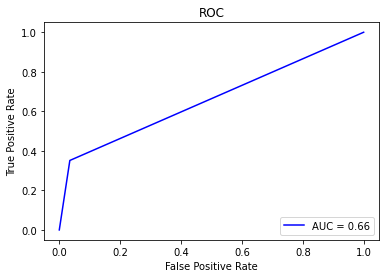

In [18]:
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SK Example 2: Telemanom

In [19]:
transformer = TelemanomSKI(l_s= 2, n_predictions= 1)
transformer.fit(X_train)
prediction_labels_train = transformer.predict(X_train)
prediction_labels_test = transformer.predict(X_test)
prediction_score = transformer.predict_score(X_test)

125/125 [==============================] - 1s 7ms/step - loss: 0.0134 - val_loss: 0.0051


In [20]:
print("Prediction Labels\n", prediction_labels_test)
print("Prediction Score\n", prediction_score)

Prediction Labels
 [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
Prediction Score
 [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [21]:
y_true = prediction_labels_train
y_pred = prediction_labels_test
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
f1_scores = 2*recall*precision/(recall+precision)
fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

In [22]:
print('Accuracy Score: ', accuracy_score(y_true, y_pred))

Accuracy Score:  0.18055416624987497


In [23]:
confusion_matrix(y_true, y_pred)

array([[ 958, 8039],
       [ 153,  847]])

In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.11      0.19      8997
           1       0.10      0.85      0.17      1000

    accuracy                           0.18      9997
   macro avg       0.48      0.48      0.18      9997
weighted avg       0.79      0.18      0.19      9997



In [25]:
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0
Best F1-Score:  0.18186778212239701


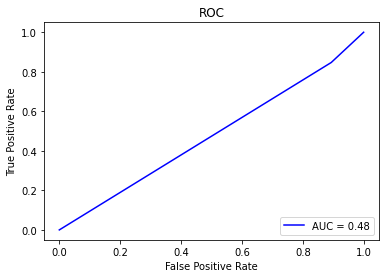

In [26]:
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Pipline Example: AutoEncoder

### Build Pipeline

In [27]:
# Creating pipeline
pipeline_description = Pipeline()
pipeline_description.add_input(name='inputs')

'inputs.0'

In [28]:
# Step 0: dataset_to_dataframe
step_0 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.data_processing.dataset_to_dataframe'))
step_0.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='inputs.0')
step_0.add_output('produce')
pipeline_description.add_step(step_0)

While loading primitive 'tods.data_processing.dataset_to_dataframe', an error has been detected: (scikit-learn 0.22.2.post1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('scikit-learn==0.22.0'))
Attempting to load primitive 'tods.data_processing.dataset_to_dataframe' without checking requirements.


In [29]:
# Step 1: column_parser
step_1 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.data_processing.column_parser'))
step_1.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.0.produce')
step_1.add_output('produce')
pipeline_description.add_step(step_1)

While loading primitive 'tods.data_processing.column_parser', an error has been detected: (scikit-learn 0.22.2.post1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('scikit-learn==0.22.0'))
Attempting to load primitive 'tods.data_processing.column_parser' without checking requirements.


In [30]:
# Step 2: extract_columns_by_semantic_types(attributes)
step_2 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.data_processing.extract_columns_by_semantic_types'))
step_2.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.1.produce')
step_2.add_output('produce')
step_2.add_hyperparameter(name='semantic_types', argument_type=ArgumentType.VALUE,
							  data=['https://metadata.datadrivendiscovery.org/types/Attribute'])
pipeline_description.add_step(step_2)

While loading primitive 'tods.data_processing.extract_columns_by_semantic_types', an error has been detected: (scikit-learn 0.22.2.post1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('scikit-learn==0.22.0'))
Attempting to load primitive 'tods.data_processing.extract_columns_by_semantic_types' without checking requirements.


In [31]:
# Step 3: extract_columns_by_semantic_types(targets)
step_3 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.data_processing.extract_columns_by_semantic_types'))
step_3.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.0.produce')
step_3.add_output('produce')
step_3.add_hyperparameter(name='semantic_types', argument_type=ArgumentType.VALUE,
							data=['https://metadata.datadrivendiscovery.org/types/TrueTarget'])
pipeline_description.add_step(step_3)

In [32]:
attributes = 'steps.2.produce'
targets = 'steps.3.produce'

In [33]:
# Step 4: processing
step_4 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.feature_analysis.statistical_maximum'))
step_4.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference=attributes)
step_4.add_output('produce')
pipeline_description.add_step(step_4)

While loading primitive 'tods.feature_analysis.statistical_maximum', an error has been detected: (scikit-learn 0.22.2.post1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('scikit-learn==0.22.0'))
Attempting to load primitive 'tods.feature_analysis.statistical_maximum' without checking requirements.


In [34]:
# Step 5: algorithm`
step_5 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.detection_algorithm.pyod_ae'))
step_5.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.4.produce')
step_5.add_output('produce')
pipeline_description.add_step(step_5)

While loading primitive 'tods.detection_algorithm.pyod_ae', an error has been detected: (scikit-learn 0.22.2.post1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('scikit-learn==0.22.0'))
Attempting to load primitive 'tods.detection_algorithm.pyod_ae' without checking requirements.


In [35]:
# Step 6: Predictions
step_6 = PrimitiveStep(primitive=index.get_primitive('d3m.primitives.tods.data_processing.construct_predictions'))
step_6.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.5.produce')
step_6.add_argument(name='reference', argument_type=ArgumentType.CONTAINER, data_reference='steps.1.produce')
step_6.add_output('produce')
pipeline_description.add_step(step_6)

While loading primitive 'tods.data_processing.construct_predictions', an error has been detected: (scikit-learn 0.22.2.post1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('scikit-learn==0.22.0'))
Attempting to load primitive 'tods.data_processing.construct_predictions' without checking requirements.


In [36]:
# Final Output
pipeline_description.add_output(name='output predictions', data_reference='steps.6.produce')

'outputs.0'

In [37]:
# Output to json
data = pipeline_description.to_json()
with open('autoencoder_pipeline.json', 'w') as f:
    f.write(data)
    print(data)

{"id": "44caca5f-ed2a-42d6-bede-777fd96e5a90", "schema": "https://metadata.datadrivendiscovery.org/schemas/v0/pipeline.json", "created": "2021-06-29T04:06:32.108192Z", "inputs": [{"name": "inputs"}], "outputs": [{"data": "steps.6.produce", "name": "output predictions"}], "steps": [{"type": "PRIMITIVE", "primitive": {"id": "c78138d9-9377-31dc-aee8-83d9df049c60", "version": "0.3.0", "python_path": "d3m.primitives.tods.data_processing.dataset_to_dataframe", "name": "Extract a DataFrame from a Dataset"}, "arguments": {"inputs": {"type": "CONTAINER", "data": "inputs.0"}}, "outputs": [{"id": "produce"}]}, {"type": "PRIMITIVE", "primitive": {"id": "81235c29-aeb9-3828-911a-1b25319b6998", "version": "0.6.0", "python_path": "d3m.primitives.tods.data_processing.column_parser", "name": "Parses strings into their types"}, "arguments": {"inputs": {"type": "CONTAINER", "data": "steps.0.produce"}}, "outputs": [{"id": "produce"}]}, {"type": "PRIMITIVE", "primitive": {"id": "a996cd89-ddf0-367f-8e7f-8c01

### Run Pipeline

In [38]:
this_path = os.path.dirname(os.path.abspath("__file__"))
default_data_path = os.path.join(this_path, '../../datasets/anomaly/raw_data/yahoo_sub_5.csv')

In [39]:
parser = argparse.ArgumentParser(description='Arguments for running predefined pipelin.')
parser.add_argument('--table_path', type=str, default=default_data_path,
                    help='Input the path of the input data table')
parser.add_argument('--target_index', type=int, default=6,
                    help='Index of the ground truth (for evaluation)')
parser.add_argument('--metric',type=str, default='F1_MACRO',
                    help='Evaluation Metric (F1, F1_MACRO)')
parser.add_argument('--pipeline_path', 
                    default=os.path.join(this_path, 'autoencoder_pipeline.json'),
                    help='Input the path of the pre-built pipeline description')

_StoreAction(option_strings=['--pipeline_path'], dest='pipeline_path', nargs=None, const=None, default='/Users/wangyanghe/Desktop/Research/tods/examples/Demo Notebook/autoencoder_pipeline.json', type=None, choices=None, help='Input the path of the pre-built pipeline description', metavar=None)

In [40]:
args, unknown = parser.parse_known_args()
table_path = args.table_path 
target_index = args.target_index # what column is the target
pipeline_path = args.pipeline_path
metric = args.metric # F1 on both label 0 and 1

In [41]:
# Read data and generate dataset
df = pd.read_csv(table_path)
dataset = generate_dataset(df, target_index)

In [42]:
# Load the default pipeline
pipeline = load_pipeline(pipeline_path)

In [43]:
# Run the pipeline
pipeline_result = evaluate_pipeline(dataset, pipeline, metric)
print(pipeline_result)

Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

## Searcher Example:

In [44]:
table_path = '../../datasets/anomaly/raw_data/yahoo_sub_5.csv'
target_index = 6 # column of the target label
time_limit = 30 # How many seconds you wanna search

In [45]:
metric = 'F1_MACRO' # F1 on both label 0 and 1

In [46]:
# Read data and generate dataset and problem
df = pd.read_csv(table_path)
dataset = generate_dataset(df, target_index=target_index)
problem_description = generate_problem(dataset, metric)

In [47]:
# Start backend
backend = SimpleRunner(random_seed=0)

In [48]:
# Start search algorithm
search = BruteForceSearch(problem_description=problem_description,
                          backend=backend)

In [49]:
# Find the best pipeline
best_runtime, best_pipeline_result = search.search_fit(input_data=[dataset], time_limit=time_limit)
best_pipeline = best_runtime.pipeline
best_output = best_pipeline_result.output

Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_7 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_8 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_9 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_12 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_13 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_14 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_17 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_18 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_19 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_22 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_23 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_24 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_27 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_28 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_29 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_32 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_33 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_34 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_37 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_38 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_39 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 4)                

In [50]:
# Evaluate the best pipeline
best_scores = search.evaluate(best_pipeline).scores

Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_42 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_43 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 13        
_________________________________________________________________
dropout_44 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 4)               

In [51]:
print('Search History:')
for pipeline_result in search.history:
    print('-' * 52)
    print('Pipeline id:', pipeline_result.pipeline.id)
    print(pipeline_result.scores)

Search History:
----------------------------------------------------
Pipeline id: f6665410-4d1d-4695-9f00-5d5f457ef95d
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.708549    0.708549           0     0
----------------------------------------------------
Pipeline id: 34ae48fe-fb5c-4dbd-940b-00098300cb9f
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.616695    0.616695           0     0
----------------------------------------------------
Pipeline id: fc287cdb-2958-4117-8e20-ba7645caa23c
     metric    value  normalized  randomSeed  fold
0  F1_MACRO  0.55474     0.55474           0     0
----------------------------------------------------
Pipeline id: e510c088-369b-4b04-8b25-a320b4a86530
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.531302    0.531302           0     0
----------------------------------------------------
Pipeline id: b42e188a-ea92-4dc0-b7d3-8983b0e659e9
     metric     value  normalized  randomSeed  fold
0  

In [52]:
print('Best pipeline:')
print('-' * 52)
print('Pipeline id:', best_pipeline.id)
print('Pipeline json:', best_pipeline.to_json())
print('Output:')
print(best_output)
print('Scores:')
print(best_scores)

Best pipeline:
----------------------------------------------------
Pipeline id: f6665410-4d1d-4695-9f00-5d5f457ef95d
Pipeline json: {"id": "f6665410-4d1d-4695-9f00-5d5f457ef95d", "schema": "https://metadata.datadrivendiscovery.org/schemas/v0/pipeline.json", "created": "2021-06-29T04:06:53.685353Z", "inputs": [{"name": "inputs"}], "outputs": [{"data": "steps.7.produce", "name": "output predictions"}], "steps": [{"type": "PRIMITIVE", "primitive": {"id": "c78138d9-9377-31dc-aee8-83d9df049c60", "version": "0.3.0", "python_path": "d3m.primitives.tods.data_processing.dataset_to_dataframe", "name": "Extract a DataFrame from a Dataset"}, "arguments": {"inputs": {"type": "CONTAINER", "data": "inputs.0"}}, "outputs": [{"id": "produce"}]}, {"type": "PRIMITIVE", "primitive": {"id": "81235c29-aeb9-3828-911a-1b25319b6998", "version": "0.6.0", "python_path": "d3m.primitives.tods.data_processing.column_parser", "name": "Parses strings into their types"}, "arguments": {"inputs": {"type": "CONTAINER", 